In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
np.set_printoptions(precision=3)
%matplotlib inline

# Exercice 1 - Labyrinthe

On considère le problème du labyrinthe abordé dans le premier TD.
On modélise le problème par:
- un ensemble d'états $\mathcal{S}=\left\{ 1,\dots,n \right\}\times
  \left\{ 1,\dots,m \right\}$ qui correspond aux cellules,
- un ensemble d'actions $\mathcal{A}=\left\{ 0,1,2,3 \right\}$ qui correspondent respectivement à "bas", "droite", "haut", "gauche", et dont on utilisera parfois la représentation sous forme de vecteur,
- un ensemble de gains $\mathcal{R}=\left\{ 0,1 \right\}$
- un ensemble d'états appelés "murs intérieurs" $\mathcal{W}\subset \mathcal{A}$.

Les transitions sont toutes déterministes, et sont telles qu'on obtient un gain de 1 lorsqu'on se déplace vers la cellule d'arrivée depuis une cellule voisine, et un gain de 0 sinon. Si l'action choisie correspond à un déplacement non-autorisé (soit qu'il mène à l'extérieur du labyrinthe, soit qu'il mène vers un mur intérieur, soit que l'état actual est un mur intérieur), l'état reste inchangé.

On travaillera avec une valeur $\gamma=.9$ fixée.

La fonction suivante servira à représenter graphiquement le labyrinthe, les politiques, ainsi que les chemins empruntés par les politiques.

In [2]:
def plot(policy=None, path=False):
    grid_size = maze.shape
    fig, ax = plt.subplots(figsize=(grid_size[1]+1, grid_size[0]+1))
    im = ax.imshow(maze, cmap='Greys', interpolation='nearest', extent=[0, grid_size[1], 0, grid_size[0]], alpha=1)
    ax.set_xticks(np.arange(0, grid_size[1]+1, 1), minor=True)
    ax.set_yticks(np.arange(0, grid_size[0]+1, 1), minor=True)
    ax.grid(which="minor", color='black', linestyle='-', linewidth=1)
    ax.set_xticks([])
    ax.set_yticks([])
    if policy is not None:
        # Plot arrows
        for i in range(grid_size[0]):
            for j in range(grid_size[1]):
                action = policy[i, j]
                ax.text(j + 0.5, grid_size[0] - i - 0.5, action_arrows[action],
                        ha='center', va='center', fontsize=12, fontweight='bold')
        if path is True:
            cmap = pl.cm.Reds
            my_cmap = cmap(np.arange(cmap.N))
            my_cmap[:,-1] = np.linspace(0, 1, cmap.N)
            my_cmap = ListedColormap(my_cmap)

            im = ax.imshow(path_array(policy), cmap=my_cmap, interpolation='nearest', extent=[0, grid_size[1], 0, grid_size[0]], alpha=.5)
    plt.show()

Le code suivant construit un labyrinthe aléatoire de taille 30 x 30, avec des murs intérieurs qui ne sont pas tirés de façon indépendante. La case de départ est (0,0) (celle en haut à gauche), et la case d'arrivée est (29,29) (celle en bas à droite). Il est fait en sorte que ces deux cases ne soient pas murées. Les paramètres peuvent bien sûr être modifiés.

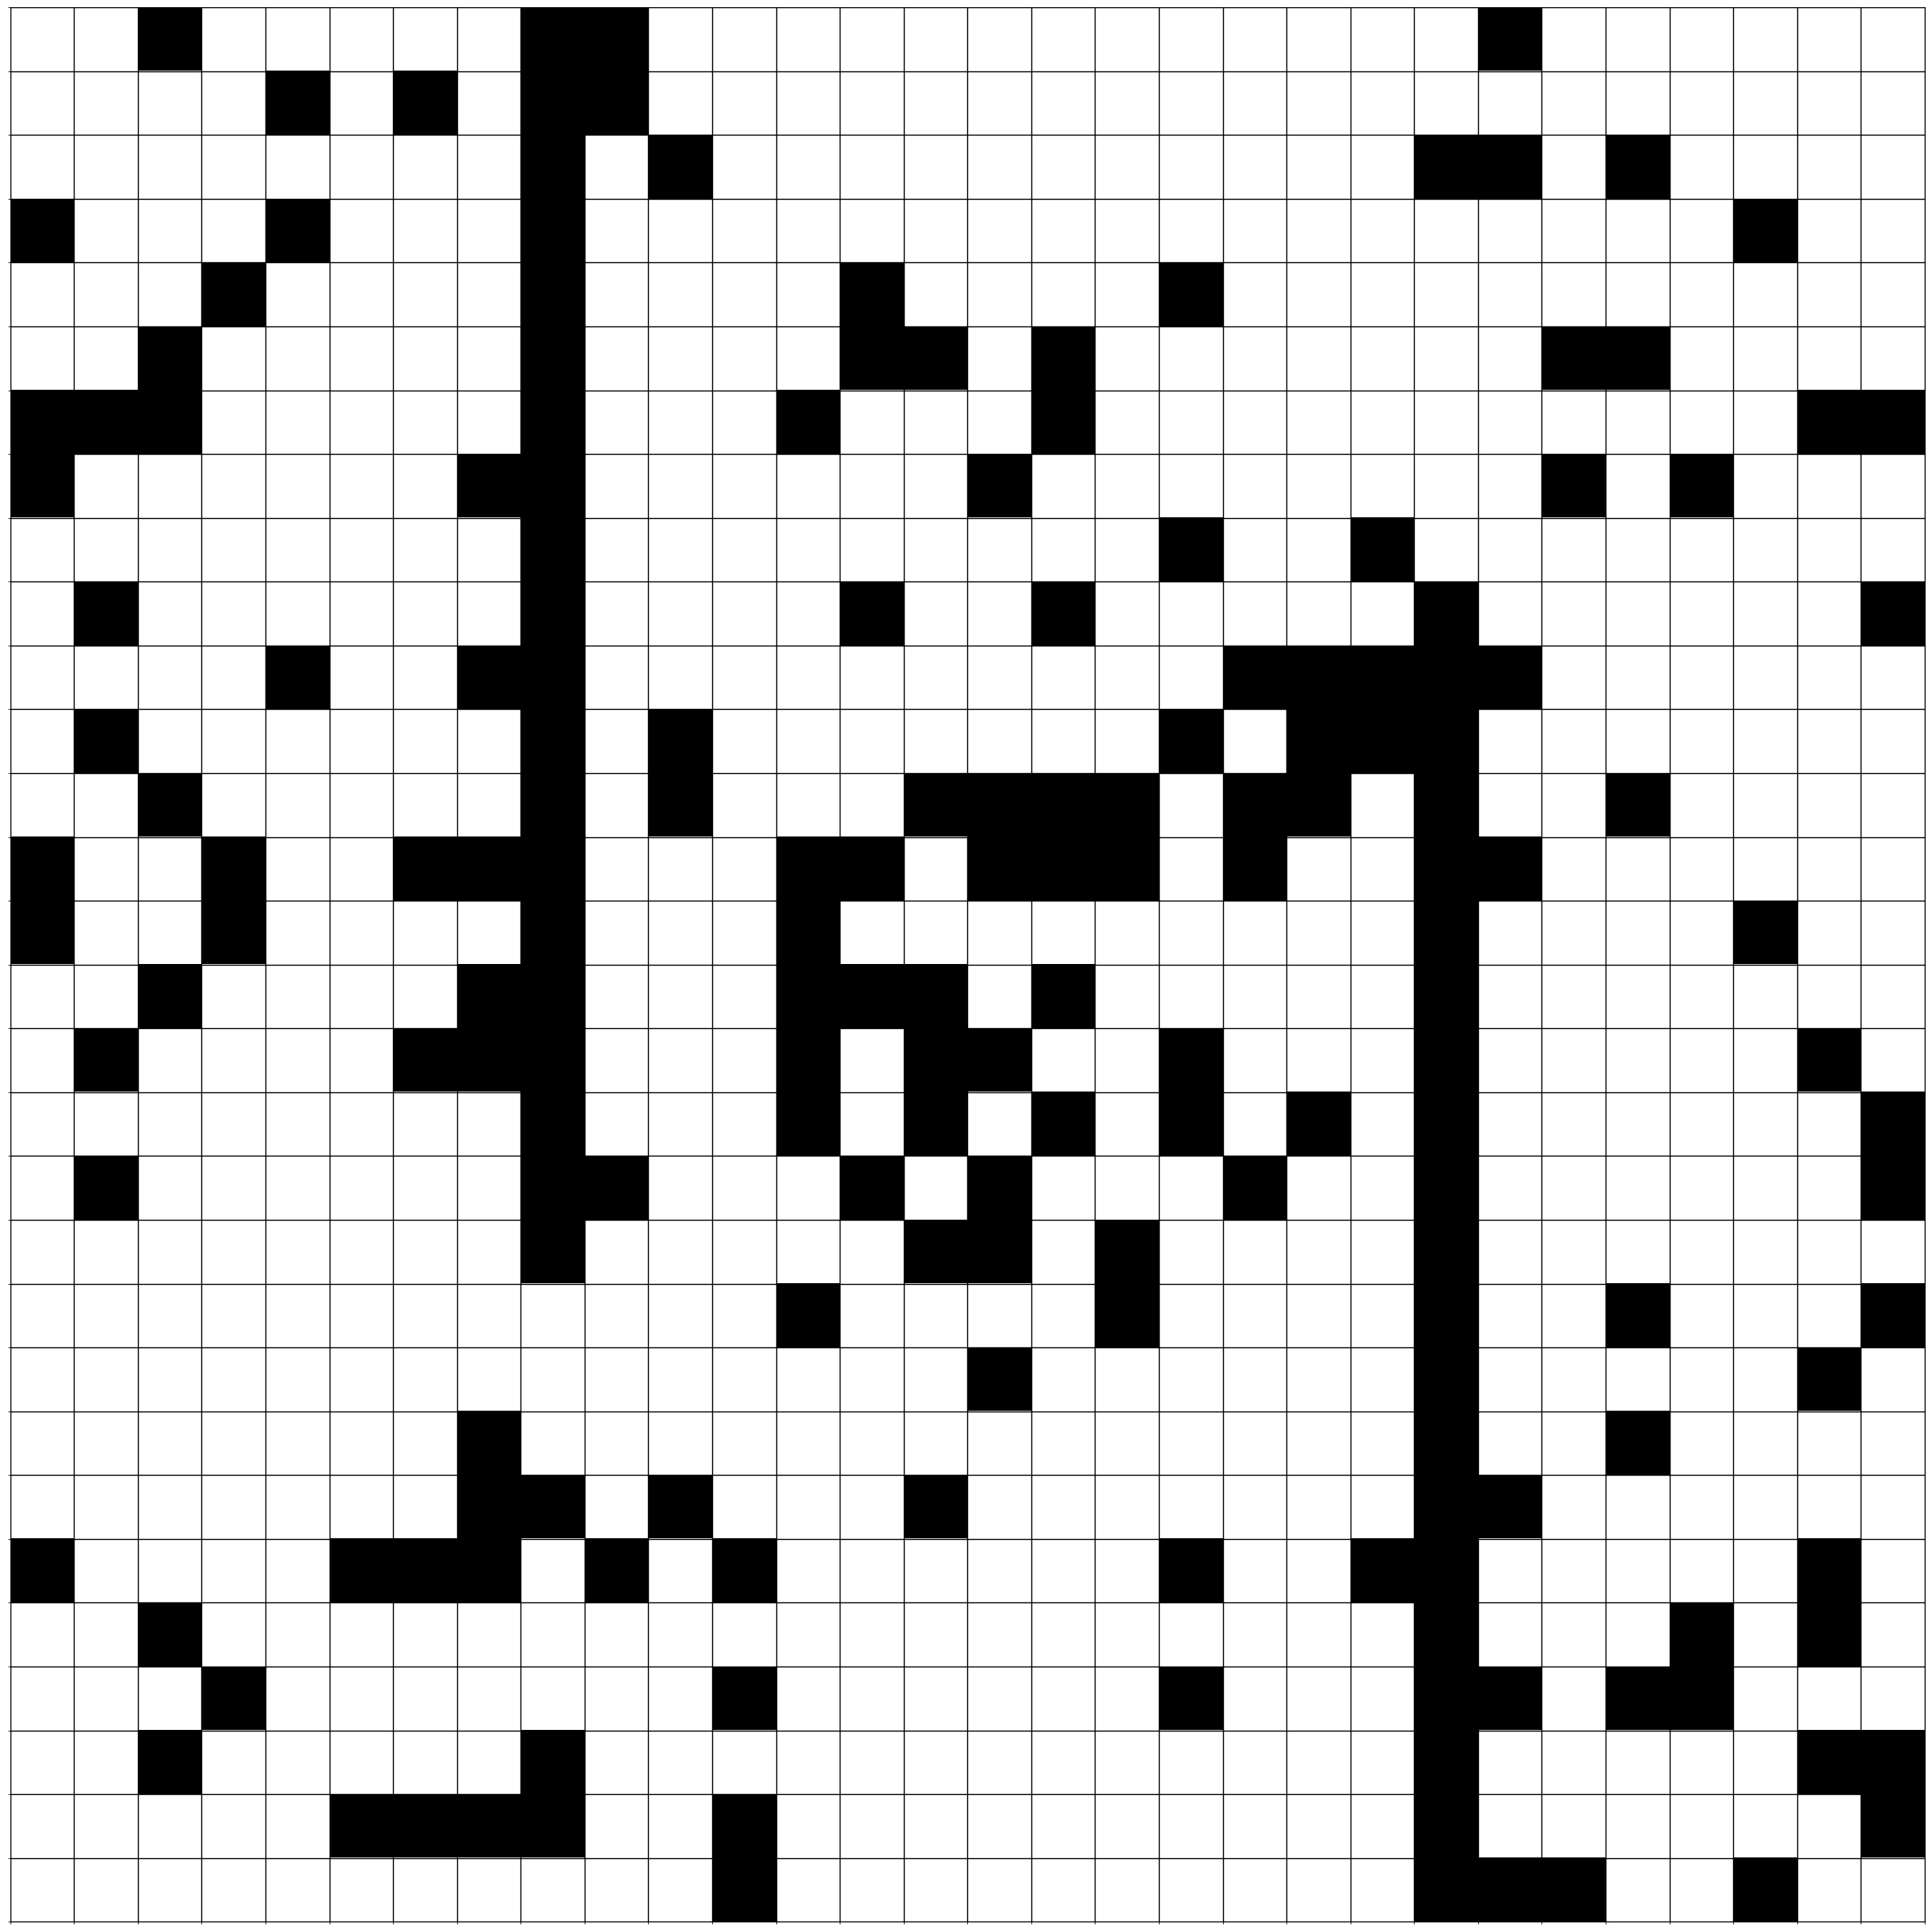

In [3]:
width = 30
height = 30
maze_size = (height, width) # nb lines & nb rows
start_cell = (0,0)
target_cell = (height-1, width-1)

maze = np.random.binomial(1, p=.15, size=maze_size)
maze[:round(2*width/3),round(height/4)] = 1
maze[round(width/3):,round(3*height/4)] = 1
chl = round(2*height/5)
chu = round(3*height/5)
cwl = round(2*width/5)
cwu = round(3*width/5)
maze[chl:chu,cwl:cwu] = np.random.binomial(1, p=.5, size=(chu-chl, cwu-cwl))
maze[start_cell] = 0
maze[target_cell] = 0
plot()

*Attention* : vérifier visuellement que le labyrinthe ainsi obtenu possède un chemin allant de la case de départ à la case d'arriver. Dans le cas contraire, relancer le code ci-dessus afin de générer un autre labyrinthe.

In [4]:
actions = [0,1,2,3]
action_coordinates = {0: np.array([1,0]),# down
                      1: np.array([0,1]), # right
                      2: np.array([-1,0]), # up
                      3: np.array([0,-1])} # left
action_arrows = ['↓', '→', '↑', '←']
gamma = .9

On ne va travailler qu'avec des politiques stationnaires déterministes $\pi:\mathcal{S}\to \mathcal{A}$. On va les représenter par des arrays de taille $n\times m$ à valeurs dans $\left\{ 0,1,2,3 \right\}$.

*Question 1*: Compléter la fonction suivante qui prend en entrée un état (un couple de la forme (i,j)) et une action (un entier parmi 0,1,2,3), et qui renvoie r, s_, qui sont respectivement le gain et le nouvel état. On pourra utiliser la fonction `tuple` qui convertit en n-uplet un objet d'un autre type.

In [5]:
def transition(s,a):
    s_ = tuple(s + action_coordinates[a])

    if maze[s] == 1:
        return 0,s
    elif s_ == target_cell:
        return 1,s_

    elif 0 <= s_[0] < maze_size[0] and 0 <= s_[1] < maze_size[1] and maze[s_] != 1:
        return 0,s_
    elif s == target_cell:
        return 0,s
    else:
        return 0,s

*Question 2*: Compléter les fonctions suivantes qui calculent l'image d'une fonction état-valeur par les opérateurs de Bellman $B_{\pi}^{(V)}$ et $B_*^{(V)}$. Une fonction état-valeur sera représentée par un array de taille $n\times m$, et une politique (qu'on suppose donc stationnaire et déterministe), par un array de taille $n\times m$ à valeurs dans $\left\{ 0,1,2,3 \right\}$.

In [12]:
def B_pi(v, pi): 
    v_ = np.empty(maze_size)
    for line in range(maze_size[0]):
        for row in range(maze_size[1]):
            s = (line,row)
            r, s_ = transition(s, pi[s])
            v_[line,row] = r + gamma*v[s_]
    return v_

def B_star(v): 
    v_ = np.empty(maze_size)
    for line in range(maze_size[0]):
        for row in range(maze_size[1]):
            s = (line,row)
            values = []
            for a in actions:
                r, s_ = transition(s, a)
                values.append(r + gamma*v[s_])
            v_[line,row] = max(values)
    return v

*Question 3*: Compléter la fonction suivante qui renvoie une politique gloutonne par rapport à une fonction état-valeur donnée en entrée. On pourra utiliser la fonction np.argmax.

In [13]:
def greedy_policy(v): 
    pi = np.empty(maze_size, dtype=int)
    for line in range(maze_size[0]):
        for row in range(maze_size[0]):
            s =  (line,row)
            values = []
            for a in actions:
                r, s_ = transition(s, a)
                values.append(r + gamma*v[s_])
            pi[line,row] = np.argmax(values)
    return pi

*Question 4*: Compléter la fonction suivante qui renvoie le chemin suivi par la politique donnée en argument depuis la cellule de départ. On considère qu'un chemin se termine lorsque qu'une transition donne une cellule déjà visitée par le chemin. Le chemin sera donné sous la forme d'un array de taille $n\times m$ à valeurs dans {0,1}, où 1 correspond aux cellules visitées par le chemin.

In [14]:
def path_array(policy):
    path = np.zeros_like(maze)
    s = start_cell
    while True:
        path[s]=1
        a = policy[s]
        _, s_ = transition(s, a)
        if path[s_] == 1 or s_ == target_cell:
            break
        s = s_
    return path

Le code suivant donne une fonction état-valeur aléatoire, qui servira de point de départ pour une itération valeur.

In [15]:
v = np.random.random(maze.shape)

*Question 5*: Calculer 50 itérations d'une itération valeur. Observer alors le chemin donné par la politique gloutonne grâce à la fonction plot appelée avec l'option path=True. Un chemin de longeur minimale a-t-il été trouvé ? Si besoin, calculer 50 itérations supplémentaires en relançant la cellule de code.

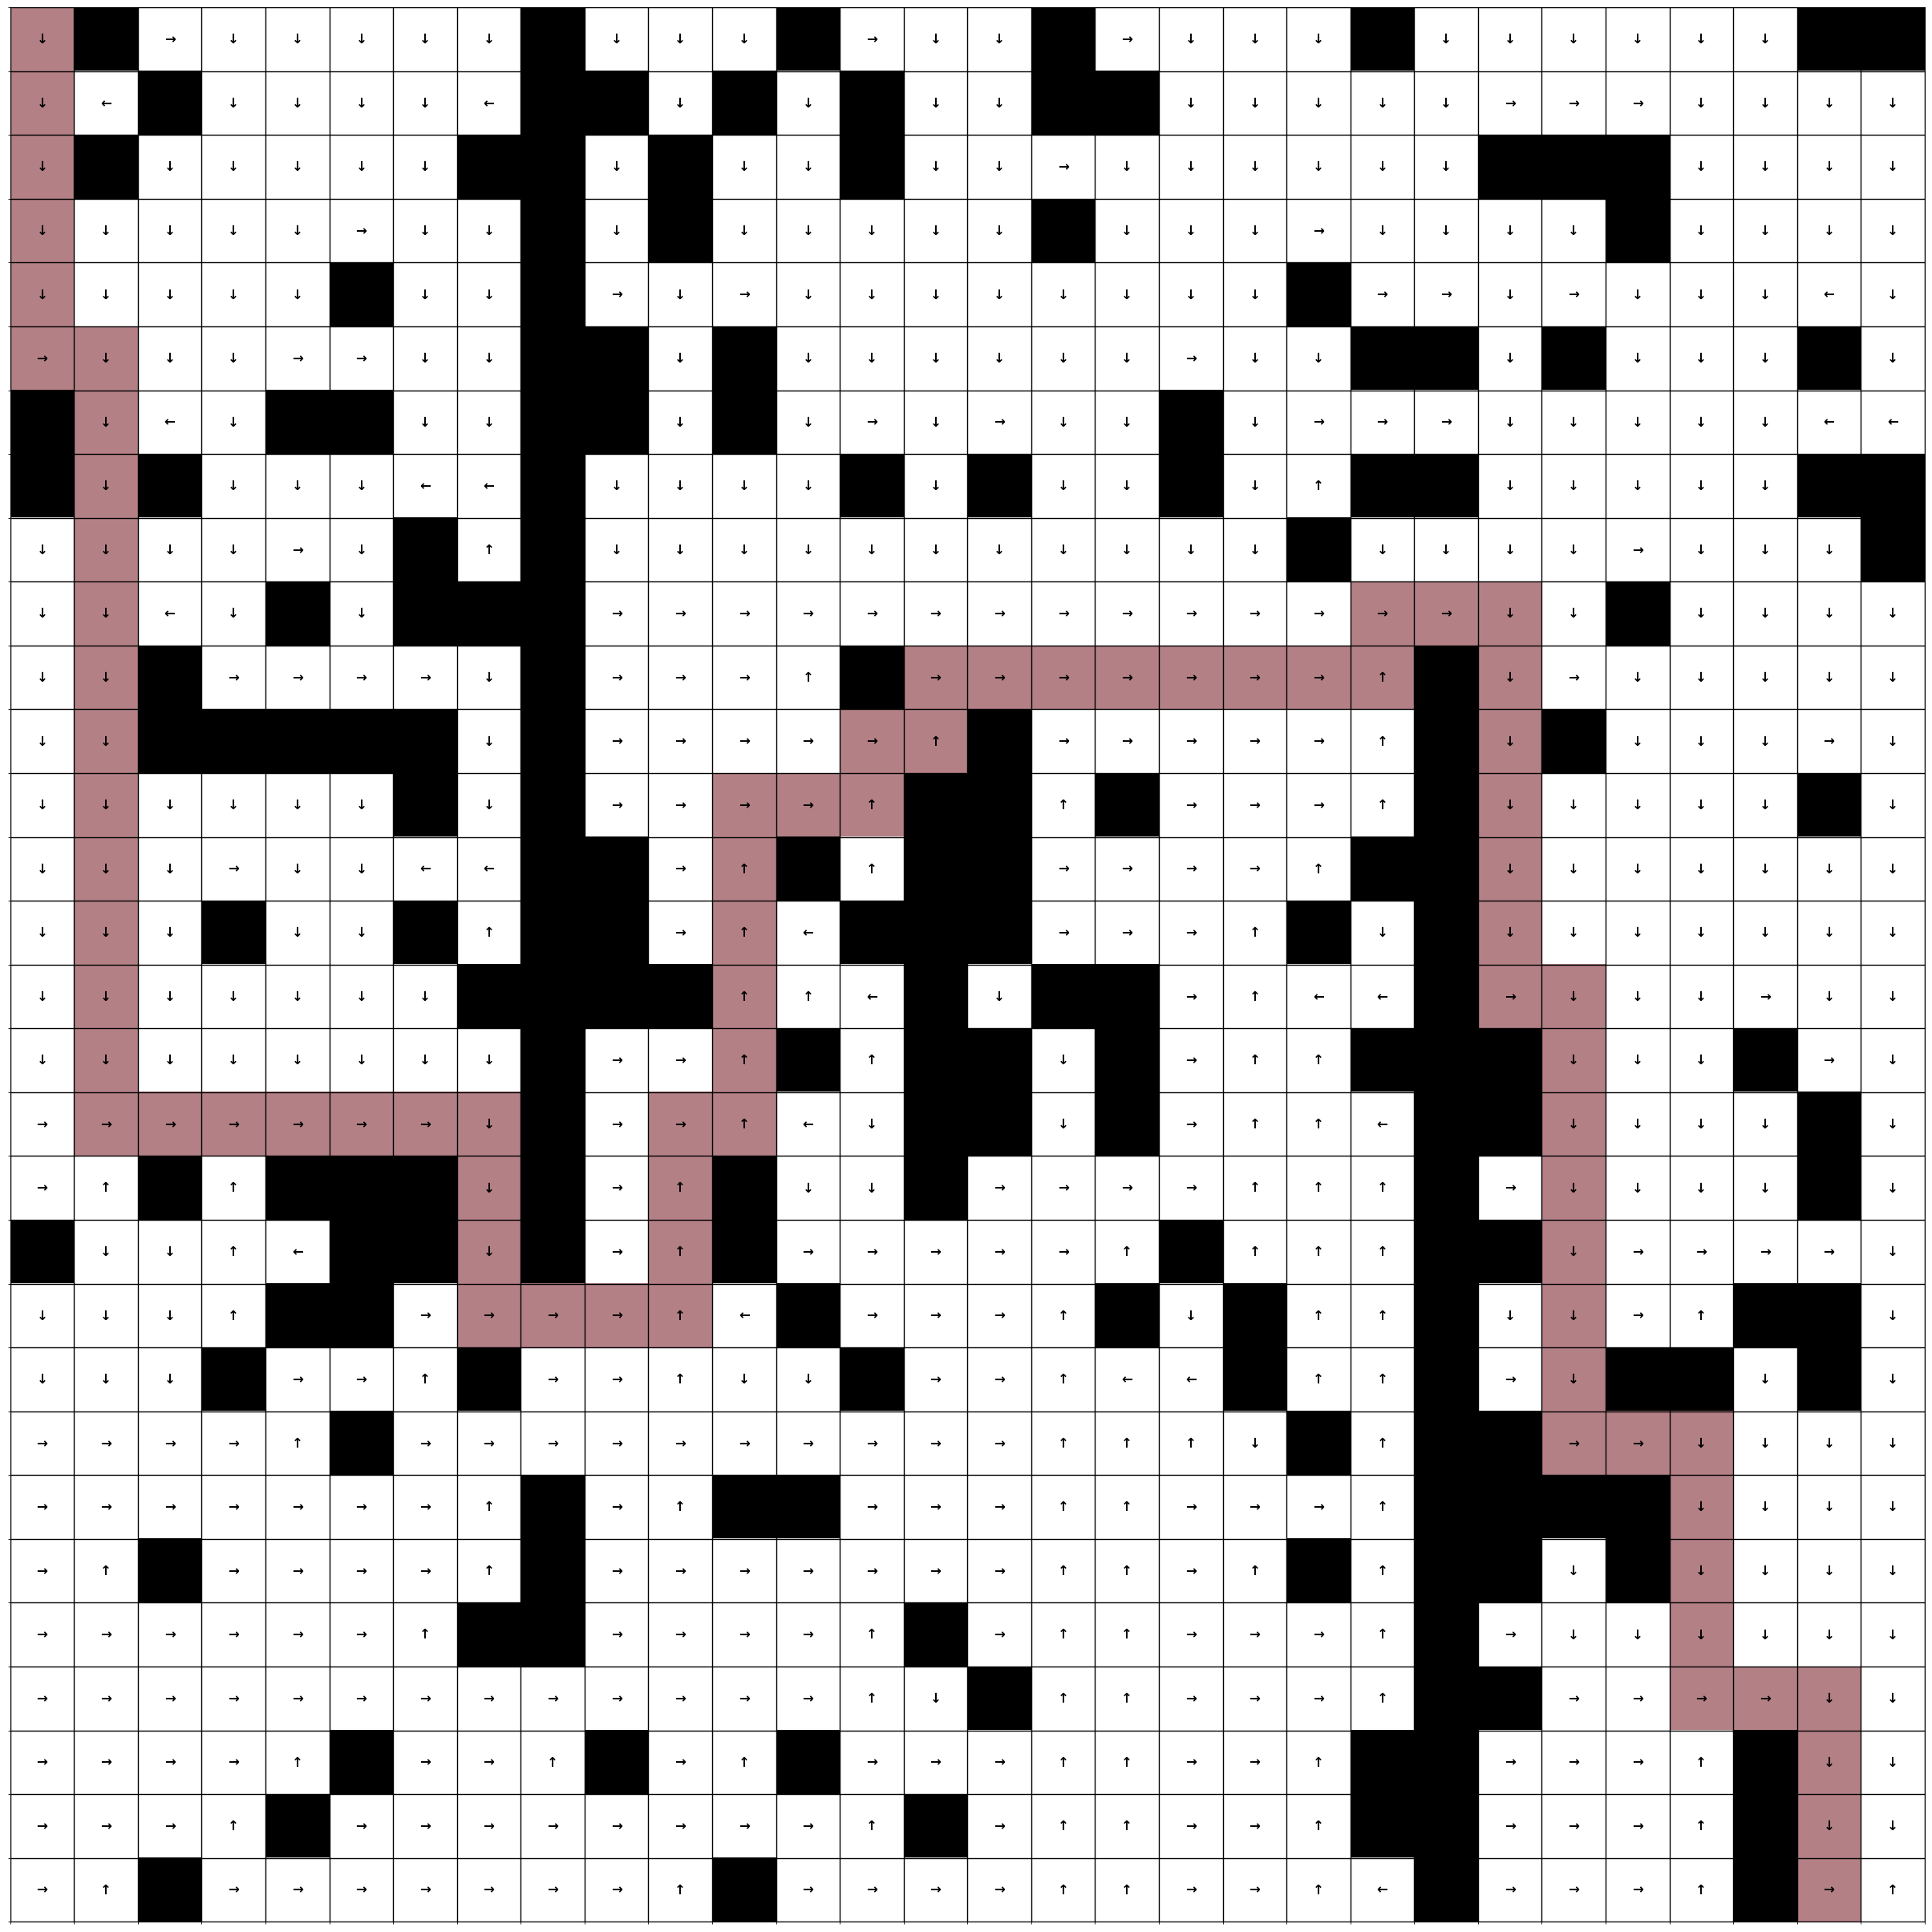

In [38]:
for k in range(50):
    v = B_star(v)
    
plot(policy=greedy_policy(v),path=True)

*Question 6*: Recommencer l'itération valeur, et s'arrêter lorsque la politique gloutonne reste inchangée pendant un certain nombre d'itérations (par exemple 100). A quelle itération cette politique a-t-elle été atteinte ? Combien de fois la fonction `transition` a-t-elle été appelée jusqu'à cette itération ?

In [72]:
v = np.random.random(maze.shape)
n = 0
transition_count = 0
pi = greedy_policy(v)
constant_policy_count = 0
constant_policy_iteration = 0

while True:
    n += 1
    v = B_star(v)
    pi_ = greedy_policy(v)
    transition_count += 2*v.shape[0]*v.shape[1]*4
    if np.all(pi == pi_):
        if constant_policy_count == 0:
            constant_policy_iteration = n
        constant_policy_count += 1
    else:
        constant_policy_count = 0
    pi = pi_
    if constant_policy_count == 100:
        break
        
print("Policy attained at iteration", constant_policy_iteration)
print("Transition function called", transition_count, " times")

Policy attained at iteration 85
Transition function called 1324800  times


*Question 7*: Implémenter une itération de politique, où pour chaque politique $\pi$ considérée, $v_{\pi}$ est approximée par 5 itérations de $B_{\pi}$. Combien de fois la fonction `transition` a-t-elle été appelée jusqu'à ce que la politique obtenue semble avoir convergé ?

In [73]:
v = np.random.random(maze.shape)
n = 0
transition_count = 0
pi = greedy_policy(v)
constant_policy_count = 0
constant_policy_iteration = 0

while True:
    n += 1        
    v = B_star(B_star(B_star(B_star(B_star(v)))))
    pi_ = greedy_policy(v)
    transition_count += 6*v.shape[0]*v.shape[1]*4
    
    if np.all(pi == pi_):
        if constant_policy_count == 0:
            constant_policy_iteration = n
        constant_policy_count += 1
    else:
        constant_policy_count = 0
    pi = pi_
    if constant_policy_count == 100:
        break
        
print("Policy attained at iteration", constant_policy_iteration)
print("Transition function called", transition_count, " times")

Policy attained at iteration 18
Transition function called 2527200  times


# Exercice 2 - Le plus grand nombre à 5 chiffres

On considère à nouveau le problème rencontré dans le TD/TP 1. Le but de l'agent est de former un nombre à 5 chiffres, le plus grand possible. On considère 5 emplacements, initialement vides, correspondant aux chiffre des unités, des dizaines, des centaines, des milliers, et des dizaines de milliers. À chaque étape, un chiffre (entre 0 et 9) est tiré uniformément et présenté à l'agent. Celui-ci doit le placer dans l'un des emplacements disponibles. Le nombre est donc formé au bout de 5 étapes.

On modélise le problème par un MDP dont
- l'espace d'états est $\mathcal{S}=\left\{ 0,1 \right\}^5\times \left\{ 0,\dots,9 \right\}$ où pour les cinq premières composantes, un 1 correspond à un emplacement libre,
- l'ensemble de paiements est $\mathcal{R}=\left\{ 0,1,\dots,99999 \right\}$,
- l'ensemble d'actions est $\mathcal{A}=\left\{ 1,\dots,5 \right\}$,
- la dynamique de transition est 
$$p(\,\cdot\,|s,a)= \begin{cases} \delta_0\otimes \delta_s&\text{si $s^{(a)}=0$}\\ 
\delta_{10^{a-1}s^{(6)}} \otimes \delta_{\sigma(s,a)}\otimes
\mathcal{U}(\left\{ 0,\dots,9 \right\})&\text{si $s^{(a)}=1$}.
\end{cases}$$

On considère un paiement non-escompté ($\gamma=1$, même si cela ne rentre pas strictement dans le cadre théorique du cours) et une distribution pour l'état initial $\mu=\delta_{(1,1,1,1,1)}\otimes \mathcal{U}(\left\{ 0,\dots,9 \right\})$.

In [2]:
import random
import math
import numpy as np

# Liste contenant les états sous la forme de tuples
S = [(i1,i2,i3,i4,i5,i6) for i1 in [0,1] for i2 in [0,1] for i3 in [0,1] for i4 in [0,1] for i5 in [0,1] for i6 in range(10)]

**Question 1 :** Compléter les fonctions suivantes qui calculent $B_\pi$ et $B_*$ dans l'espace des fonctions état-valeur. Les arguments `v` et `pi` sont ici des dictonnaires dont les clés sont les états représentés sous la forme de tuples comme dans l'ensemble ci-dessus. On suppose qu'on ne travaille qu'avec politiques stationnaires et déterministes.

In [3]:
def sigma(s,a):
    number = list(s[:5])
    number[a-1] = 0
    return number

def B_pi(v,pi):
    v_ = v.copy()
    for s in S:
        a = pi[s]
        number = sigma(s,a)
        if s[a-1] == 1:
            v_[s] = 10**(a-1)*s[5] + sum([v[tuple(number+[i])] for i in range(10)])/10
    return v_

def B_star(v):
    v_ = v.copy()
    for s in S:
        values = [0]
        for a in [1,2,3,4,5]:
            if s[a-1] == 1:
                number = sigma(s,a)
                values.append(10**(a-1)*s[5] + sum([v[tuple(number+[i])] for i in range(10)])/10)
        v_[s] = max(values)
    return v_

**Question 2 :** Compléter la fonction suivante qui pour une fonction état-valeur $v$ donnée calcule la quantité
$$\mathbb{E}_{S\sim\mu}\left[ v(S) \right].$$

In [4]:
def avg_reward(v):
    return sum([v[(1,1,1,1,1,i)] for i in range(10)])/10

**Question 3 :** Compléter la fonction suivante qui détermine une politique gloutonne par rapport à une fonction valeur donnée.

In [5]:
def greedy_policy(v):
    pi = dict()
    for s in S:
        values = []
        for a in [1,2,3,4,5]:
            if s[a-1] == 1:
                number = sigma(s,a)
                values.append(10**(a-1)*s[5] + sum([v[tuple(number+[i])] for i in range(10)])/10)
            else:
                values.append(0)
        pi[s] = 1+np.argmax(np.array(values))
    return pi

**Question 4 :**  En utilisant une itération valeur (resp. une itération de politique), déterminer une politique optimale $\pi^*$, ainsi que le paiement associé
$$\mathbb{E}_{\mu,\pi^*}\left[ \sum_{t=1}^{+\infty}R_t\right].$$ Y inclure un critère d'arrêt en supposant que l'optimalité sera atteinte en un nombre fini d'itérations. On partira d'une fonction valeur initiale nulle.

In [6]:
# Itéraiton valeur
v = dict()
for s in S:
    v[s] = 0.
n=0
while True:
    v_ = B_star(v)
    if v_ == v:
        print('Fixed point obtained after', n, 'iterations')
        print('Avg reward', avg_reward(v))
        break
    else:
        v = v_
        n += 1
greedy_policy(v)

Fixed point obtained after 5 iterations
Avg reward 78733.8045


{(0, 0, 0, 0, 0, 0): 1,
 (0, 0, 0, 0, 0, 1): 1,
 (0, 0, 0, 0, 0, 2): 1,
 (0, 0, 0, 0, 0, 3): 1,
 (0, 0, 0, 0, 0, 4): 1,
 (0, 0, 0, 0, 0, 5): 1,
 (0, 0, 0, 0, 0, 6): 1,
 (0, 0, 0, 0, 0, 7): 1,
 (0, 0, 0, 0, 0, 8): 1,
 (0, 0, 0, 0, 0, 9): 1,
 (0, 0, 0, 0, 1, 0): 1,
 (0, 0, 0, 0, 1, 1): 5,
 (0, 0, 0, 0, 1, 2): 5,
 (0, 0, 0, 0, 1, 3): 5,
 (0, 0, 0, 0, 1, 4): 5,
 (0, 0, 0, 0, 1, 5): 5,
 (0, 0, 0, 0, 1, 6): 5,
 (0, 0, 0, 0, 1, 7): 5,
 (0, 0, 0, 0, 1, 8): 5,
 (0, 0, 0, 0, 1, 9): 5,
 (0, 0, 0, 1, 0, 0): 1,
 (0, 0, 0, 1, 0, 1): 4,
 (0, 0, 0, 1, 0, 2): 4,
 (0, 0, 0, 1, 0, 3): 4,
 (0, 0, 0, 1, 0, 4): 4,
 (0, 0, 0, 1, 0, 5): 4,
 (0, 0, 0, 1, 0, 6): 4,
 (0, 0, 0, 1, 0, 7): 4,
 (0, 0, 0, 1, 0, 8): 4,
 (0, 0, 0, 1, 0, 9): 4,
 (0, 0, 0, 1, 1, 0): 4,
 (0, 0, 0, 1, 1, 1): 4,
 (0, 0, 0, 1, 1, 2): 4,
 (0, 0, 0, 1, 1, 3): 4,
 (0, 0, 0, 1, 1, 4): 4,
 (0, 0, 0, 1, 1, 5): 5,
 (0, 0, 0, 1, 1, 6): 5,
 (0, 0, 0, 1, 1, 7): 5,
 (0, 0, 0, 1, 1, 8): 5,
 (0, 0, 0, 1, 1, 9): 5,
 (0, 0, 1, 0, 0, 0): 1,
 (0, 0, 1, 0, 0,

In [8]:
# Itération de politique
v = dict()
for s in S:
    v[s] = 0.
pi = dict()
for s in S:
    pi[s] = 5
while True:
    for m in range(5):
        v = B_pi(v,pi)
    if v == B_star(v):
        print('Optimal solution has been found')
        break
    pi = greedy_policy(v)
print('Avg reward', avg_reward(v))
pi

Optimal solution has been found
Avg reward 78733.8045


{(0, 0, 0, 0, 0, 0): 1,
 (0, 0, 0, 0, 0, 1): 1,
 (0, 0, 0, 0, 0, 2): 1,
 (0, 0, 0, 0, 0, 3): 1,
 (0, 0, 0, 0, 0, 4): 1,
 (0, 0, 0, 0, 0, 5): 1,
 (0, 0, 0, 0, 0, 6): 1,
 (0, 0, 0, 0, 0, 7): 1,
 (0, 0, 0, 0, 0, 8): 1,
 (0, 0, 0, 0, 0, 9): 1,
 (0, 0, 0, 0, 1, 0): 1,
 (0, 0, 0, 0, 1, 1): 5,
 (0, 0, 0, 0, 1, 2): 5,
 (0, 0, 0, 0, 1, 3): 5,
 (0, 0, 0, 0, 1, 4): 5,
 (0, 0, 0, 0, 1, 5): 5,
 (0, 0, 0, 0, 1, 6): 5,
 (0, 0, 0, 0, 1, 7): 5,
 (0, 0, 0, 0, 1, 8): 5,
 (0, 0, 0, 0, 1, 9): 5,
 (0, 0, 0, 1, 0, 0): 1,
 (0, 0, 0, 1, 0, 1): 4,
 (0, 0, 0, 1, 0, 2): 4,
 (0, 0, 0, 1, 0, 3): 4,
 (0, 0, 0, 1, 0, 4): 4,
 (0, 0, 0, 1, 0, 5): 4,
 (0, 0, 0, 1, 0, 6): 4,
 (0, 0, 0, 1, 0, 7): 4,
 (0, 0, 0, 1, 0, 8): 4,
 (0, 0, 0, 1, 0, 9): 4,
 (0, 0, 0, 1, 1, 0): 4,
 (0, 0, 0, 1, 1, 1): 4,
 (0, 0, 0, 1, 1, 2): 4,
 (0, 0, 0, 1, 1, 3): 4,
 (0, 0, 0, 1, 1, 4): 4,
 (0, 0, 0, 1, 1, 5): 5,
 (0, 0, 0, 1, 1, 6): 5,
 (0, 0, 0, 1, 1, 7): 5,
 (0, 0, 0, 1, 1, 8): 5,
 (0, 0, 0, 1, 1, 9): 5,
 (0, 0, 1, 0, 0, 0): 1,
 (0, 0, 1, 0, 0,